In [ ]:
# Install required python packages

# For Linux and Mac
#%pip install -U "qiskit[visualization]", qiskit_ibm_runtime

#%pip install networkx

#%pip install docplex


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.5/645.5 kB 1.5 MB/s eta 0:00:001.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.29.241-py3-none-any.whl size=685423 sha256=7cb414a5f6b3143ed7d7ed9f5835e0ee87fd95cc30143131f6d5e75f59827a6d
  Stored in directory: /home/gari/.cache/pip/wheels/2b/15/6e/eba2382ab6bc3f35194a62d3b007916ececf6f07139cac6795
Successfully built docplex

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# All imports
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import heapq
import json

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicProvider
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
from qiskit.circuit.parametervector import ParameterVector
from qiskit.circuit.library import QuadraticForm
from qiskit.circuit.library import qaoa_ansatz
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

from docplex.mp.model import Model

from qiskit_ibm_runtime import SamplerV2 as Sampler

from typing import Sequence

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import time

import pickle
import os
import seaborn as sns
#from qaoa import QAOA

In [112]:
## Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(

    channel="ibm_quantum",

    token= "4b3b168f776ad0725ccaae34354440ecaf8bc4cbc78a39da7869cde362a824a4002b0b893337ac6a2da8592d3adba790312f3e60dede0ed048e8bba46a245f0f",

    set_as_default=True,

    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

# Load saved credentials
service = QiskitRuntimeService()

In [2]:
hardware = False
if hardware:
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)
else:
    backend = BasicProvider().get_backend("basic_simulator")


## GRAPH GENERATOR

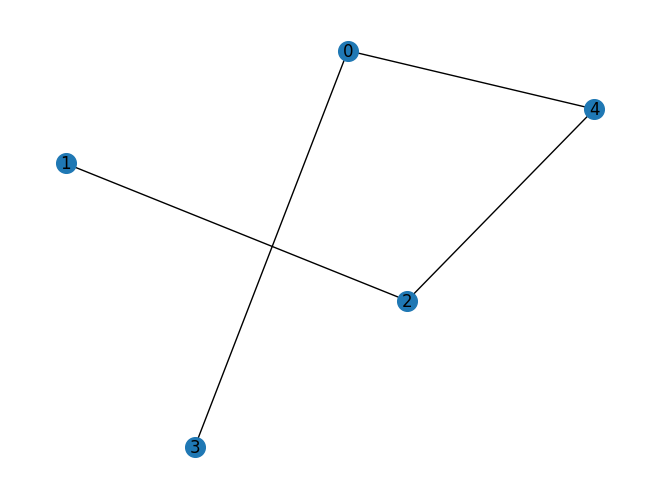

In [3]:
def generate_connected_er_graphs(n_nodes, batch_size, p_connection, seed=None):
    if seed is not None:
        np.random.seed(seed)

    batch = np.zeros((batch_size, n_nodes, n_nodes), dtype=np.int32)

    for b in range(batch_size):
        connected = False
        while not connected:
            g = nx.erdos_renyi_graph(n_nodes, p_connection)
            connected = nx.is_connected(g)

        # Convert to adjacency matrix
        adj = nx.to_numpy_array(g, dtype=np.int32)
        np.fill_diagonal(adj, 0)  # No self-loops

        batch[b] = adj

    return batch

# Parameters
n = 5
p_connection = 0.4
adj_matrix  = generate_connected_er_graphs(n, 1, p_connection, None)[0]

# Create a rustworkx PyGraph
graph_ = rx.PyGraph()
graph_.add_nodes_from(np.arange(n))

# Add edges from adjacency matrix
for i in range(n):
    for j in range(i+1, n):  # Only upper triangle to avoid duplicates
        if adj_matrix[i, j] == 1:
            graph_.add_edge(i, j, 1.0)

# Draw (you can use your existing draw_graph function)
draw_graph(graph_, node_size=200, with_labels=True, width=1)



In [102]:
import pickle
import os

def read_pickle_files_from_directory(directory):
    """
    Reads all .pkl files from a specified directory and returns them as a dictionary.

    Args:
        directory (str): The path to the directory containing the .pkl files.

    Returns:
        dict: A dictionary where keys are the filenames (without extension)
              and values are the loaded Python objects from the .pkl files.
              Returns an empty dictionary if the directory doesn't exist or
              no .pkl files are found.
    """
    loaded_files = {}
    if not os.path.isdir(directory):
        print(f"Error: Directory '{directory}' not found.")
        return loaded_files

    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'rb') as file:
                    loaded_files[filename[:-4]] = pickle.load(file)
            except Exception as e:
                print(f"Error reading file '{filename}': {e}")
    return loaded_files

# Example usage:
carpet_path = "/home/gari/Documents/QAOA/TestSample"  # Replace with the actual path to your directory
loaded_data = read_pickle_files_from_directory(carpet_path)

if loaded_data:
    print("Successfully loaded the following .pkl files:")
    for name, data in loaded_data.items():
        print(f"- {name}: {type(data)}")
        # You can now access the loaded data using the 'name' as the key, e.g., loaded_data['my_data']
else:
    print("No .pkl files found or an error occurred.")


if loaded_data:
    # Get the first key (filename without extension) from the dictionary
    first_key = next(iter(loaded_data))
    # Access the value (the loaded data) using the first key
    first_element = loaded_data[first_key]
    print(first_element)

Successfully loaded the following .pkl files:
- 15_graph_24: <class 'rustworkx.PyGraph'>
- 5_graph_5: <class 'rustworkx.PyGraph'>
- 26_graph_86: <class 'rustworkx.PyGraph'>
- 25_graph_83: <class 'rustworkx.PyGraph'>
- 10_graph_15: <class 'rustworkx.PyGraph'>
- 25_graph_76: <class 'rustworkx.PyGraph'>
- 20_graph_55: <class 'rustworkx.PyGraph'>
- 10_graph_12: <class 'rustworkx.PyGraph'>
- 15_graph_30: <class 'rustworkx.PyGraph'>
- 12_graph_18: <class 'rustworkx.PyGraph'>
- 20_graph_56: <class 'rustworkx.PyGraph'>


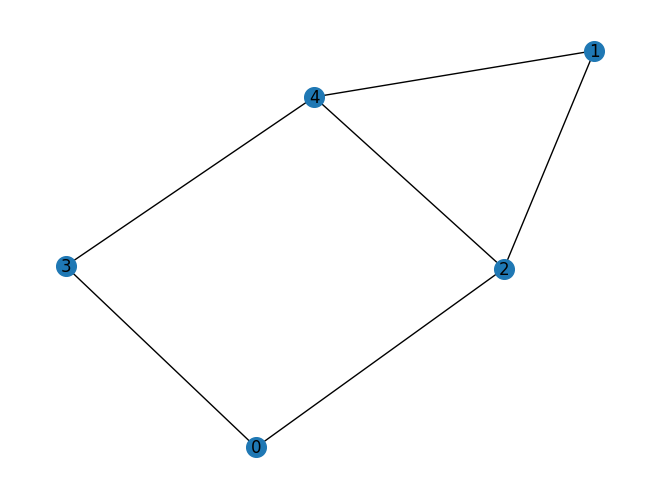

In [99]:
draw_graph(loaded_data['5_graph_5'], node_size=200, with_labels=True, width=1)

## COST HAMILTONIAN

In [100]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        #paulis = ["I"] * 127
        #print(edge)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [104]:
max_cut_graph = build_max_cut_paulis(loaded_data['5_graph_5'])

cost_hamiltonian = SparsePauliOp.from_list(max_cut_graph)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIZIZ', 'IZIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [105]:
def extract_qubit_indices(pauli_str):
    """Returns sorted tuple of qubit indices where Pauli is not 'I'."""
    return tuple(i for i, p in enumerate(pauli_str) if p != 'I')

# Zip and sort based on the qubit indices
sorted_terms = sorted(
    zip(cost_hamiltonian.paulis, cost_hamiltonian.coeffs),
    key=lambda x: extract_qubit_indices(x[0].to_label())
)

# Unpack and rebuild SparsePauliOp
sorted_paulis, sorted_coeffs = zip(*sorted_terms)
cost_hamiltonian_sorted = SparsePauliOp(list(sorted_paulis), list(sorted_coeffs))


## QAOA VARIANT

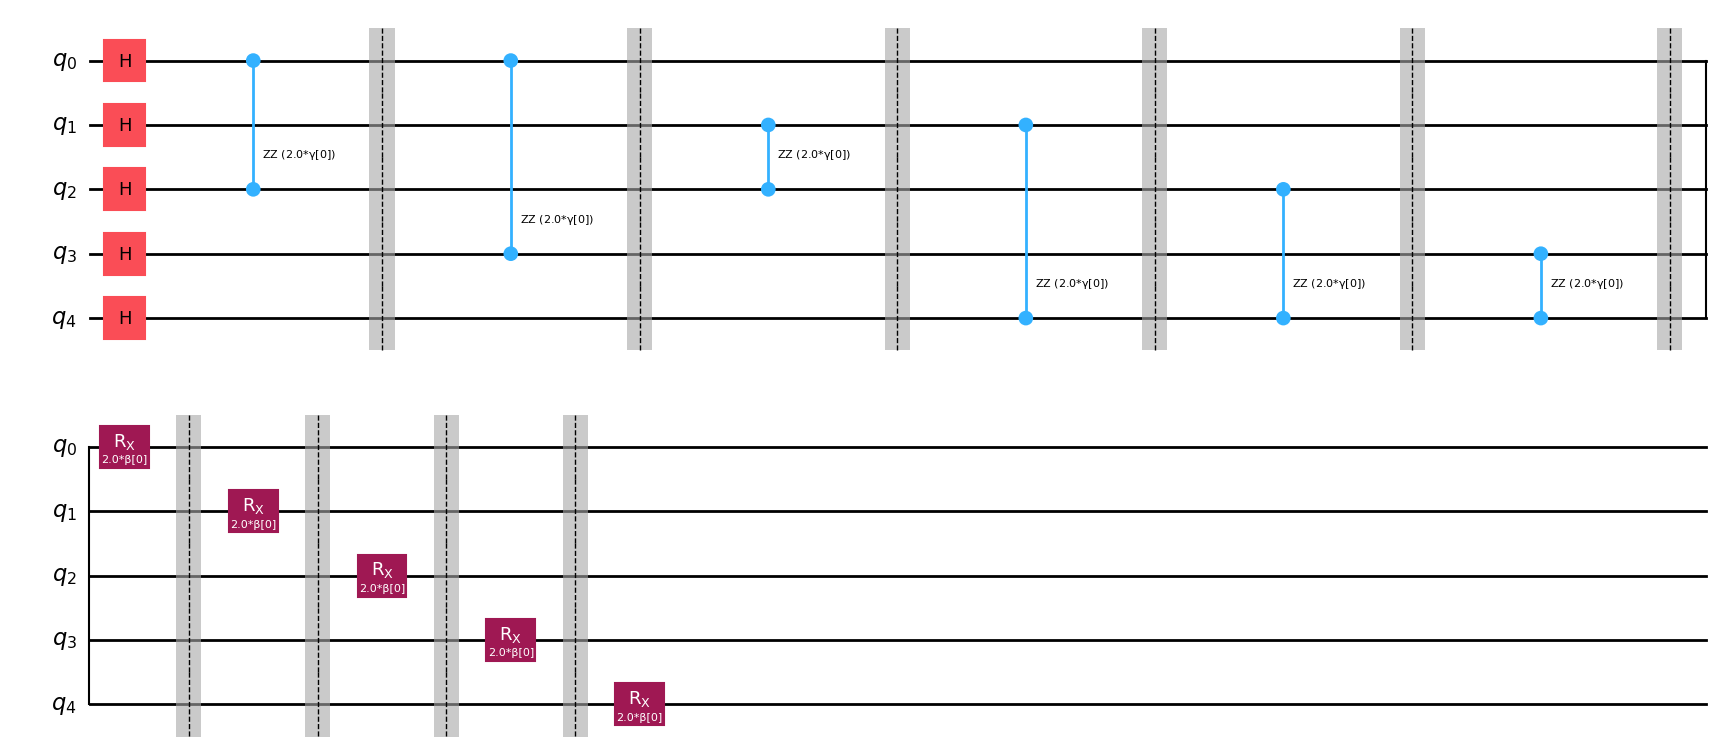

In [106]:
#QAOA ANSATZ
qaoa_ansatz = qaoa_ansatz(cost_hamiltonian, reps=1, insert_barriers=True)
qaoa_ansatz.draw("mpl")

In [ ]:
#WS-QAOA ANSATZ
#ws_qaoa_ansatz = qaoa_ansatz(cost_hamiltonian, reps=1, initial_state = , insert_barriers=True)
#ws_qaoa_ansatz.draw("mpl")

In [107]:

class QUMDA:

  def __init__(self, p: int, n_qubits: int, cost_hamiltonian):

    #Parameters
    if p > 0:
      self.p = p
    else:
      self.p = 1

    self.n_qubits = n_qubits
    self.gammas = [Parameter(f'γ_{i}') for i in range(self.p)]
    self.betas =  [Parameter(f'β_{i}') for i in range(self.p)]
    #self.thetas = self.n_qubits * [0.5]
    self.thetas = [Parameter(f'θ_{i}') for i in range(self.n_qubits)]
    #ParameterVector("β", self.reps * num_mixer)

    #Cost hamiltonian
    self.cost_hamiltonian = cost_hamiltonian

    #Parameterizable circuit
    self.qc = self.construct_circuit()


  def construct_circuit(self):

    qc = QuantumCircuit(self.n_qubits, self.n_qubits)

    # Initial state:
    qc = self.initial_state_layer(qc)

    for i in range(self.p):
      # Apply cost Hamiltonian evolution
      qc = self.cost_hamiltonian_layer(qc, self.gammas[i])

      # Apply mixing Hamiltonian (X rotation)
      qc = self.mixing_hamiltonian_layer(qc, self.betas[i])

    qc.measure_all()
    return qc

  def initial_state_layer(self, qc):
    for i in range(self.n_qubits):
        #theta = 2*np.arcsin(np.sqrt(self.thetas[i]))
        theta = self.thetas[i]
        qc.ry(theta, i)
    return qc

  def cost_hamiltonian_layer(self, qc, gamma):
    for term, coeff in zip(self.cost_hamiltonian.paulis, self.cost_hamiltonian.coeffs):
      pauli_str = term.to_label()

      qubits = [i for i, p in enumerate(pauli_str[::-1]) if p != 'I']

      if pauli_str.count('Z') == 2:
        # Two-qubit ZZ term
        i, j = qubits
        qc.cx(i, j)
        #If max-cut, not 2
        qc.rz(coeff.real * gamma, j)
        qc.cx(i, j)

      elif pauli_str.count('Z') == 1:
        # Single-qubit Z term (if present)
        i = qubits[0]
        #If max-cut, not 2
        qc.rz(coeff.real * gamma, i)

      qc.barrier()

    return qc


  def mixing_hamiltonian_layer(self, qc, beta):
    for i in range(self.n_qubits):
      #theta = 2 * np.arcsin(np.sqrt(self.thetas[i]))
      theta = self.thetas[i]
      qc.ry(-theta, i)
      qc.rz(-2* beta, i)
      qc.ry(theta, i)

    return qc

  def update_distribution(self, probability_vector):
    param_dict = {self.thetas[i]: 2*np.arcsin(np.sqrt(probability_vector[i])) for i in range(self.n_qubits)}
    qc = self.qc.assign_parameters(param_dict)
    return qc

  def update_distribution2(self, qc, probability_vector):
    param_dict = {self.thetas[i]: 2*np.arcsin(np.sqrt(probability_vector[i])) for i in range(self.n_qubits)}
    qc = qc.assign_parameters(param_dict)
    return qc



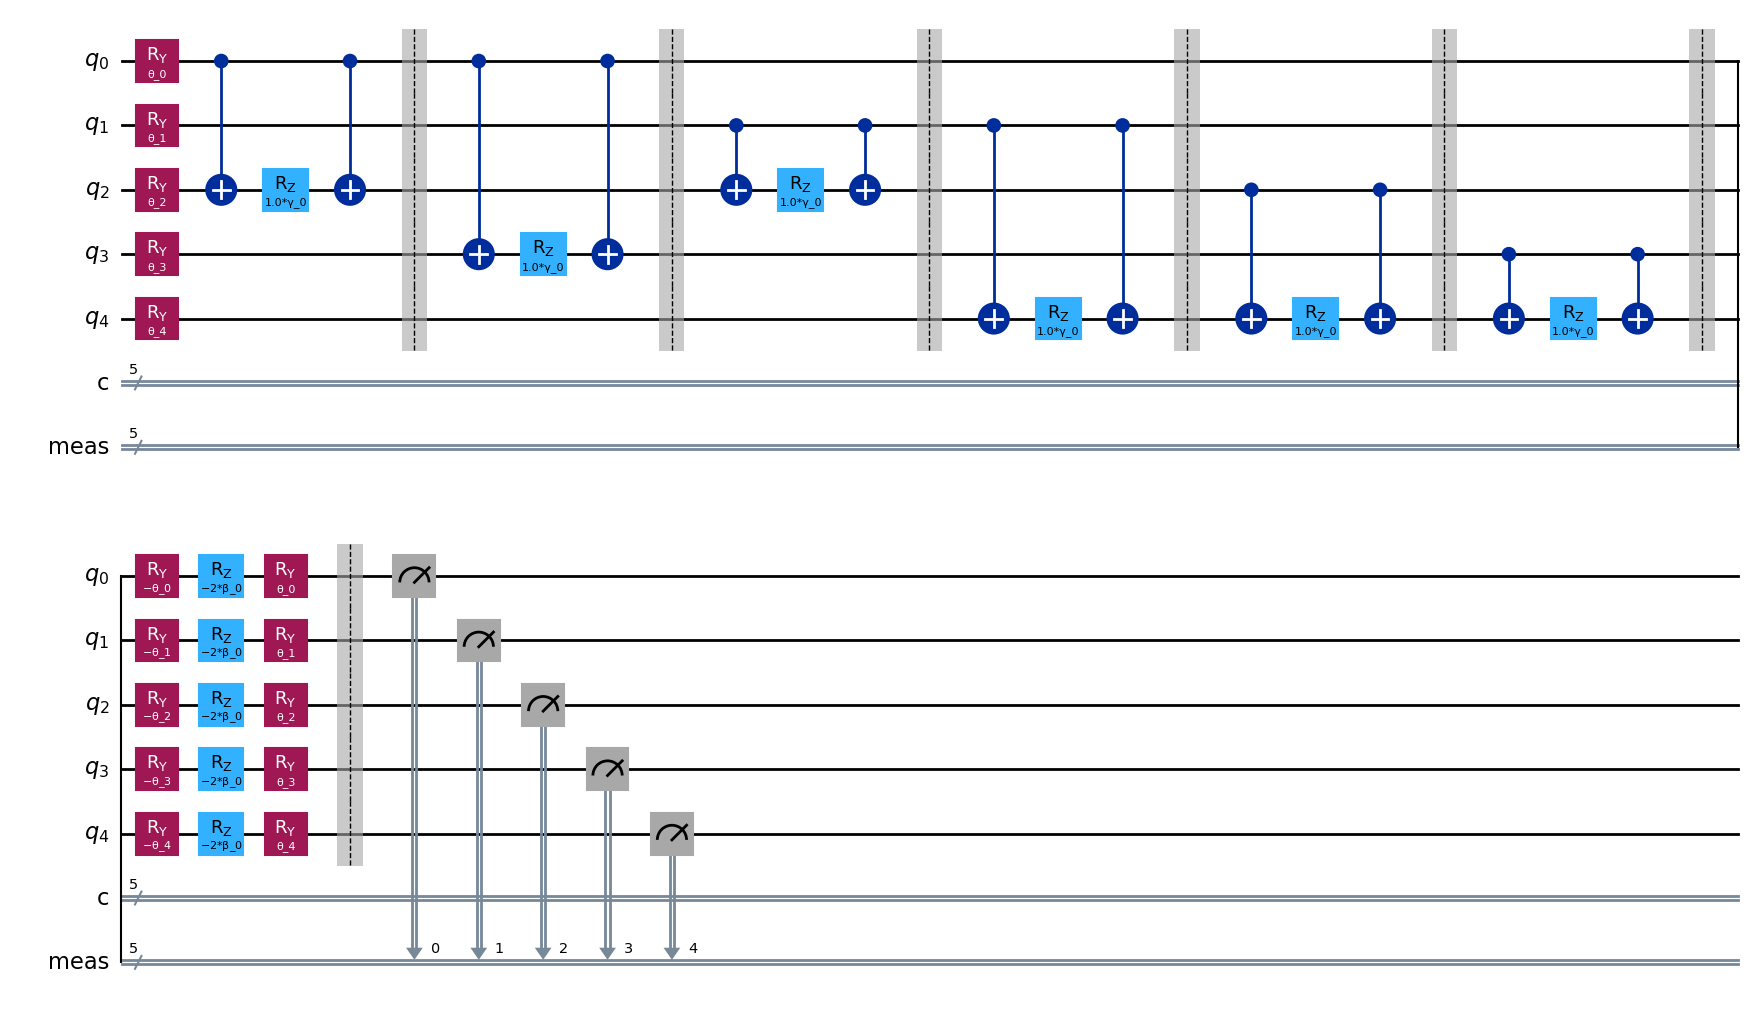

In [108]:
#MY QAOA

qumda = QUMDA(1,5, cost_hamiltonian)
qumda.qc.draw("mpl")

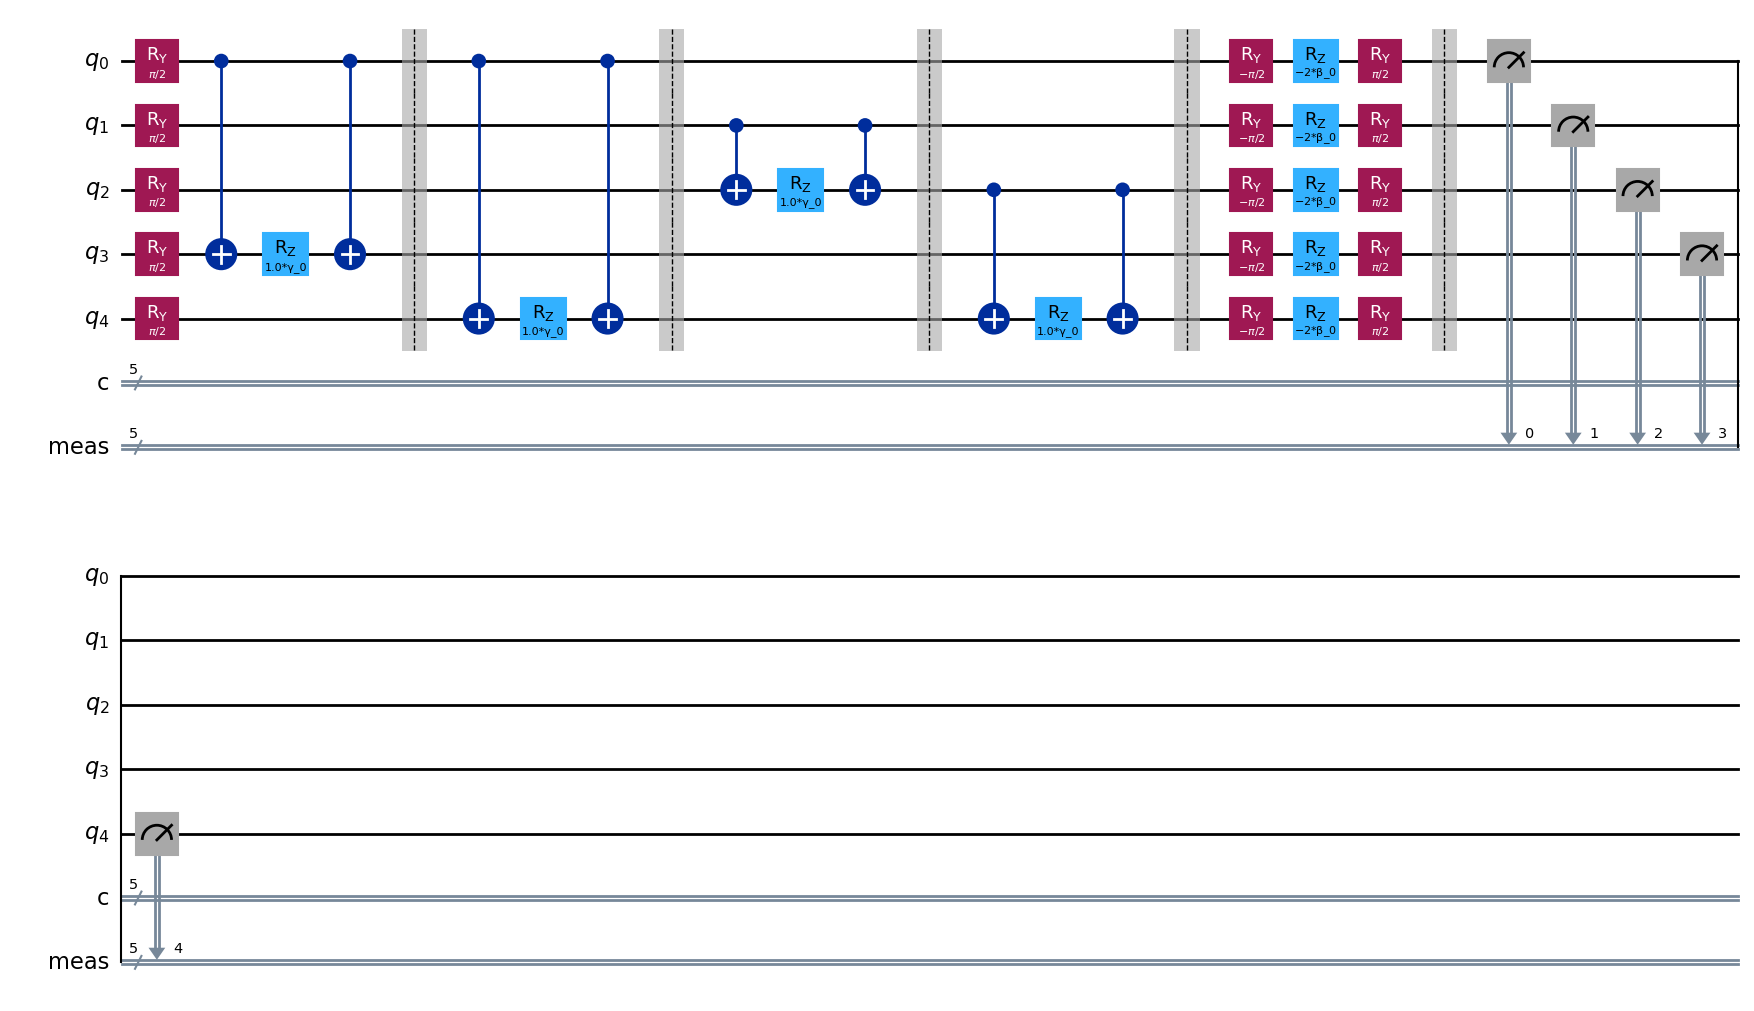

In [22]:
qumda2 = QUMDA(1,5, cost_hamiltonian)

quc = qumda2.update_distribution([0.5, 0.5, 0.5, 0.5, 0.5])
quc.draw("mpl")

In [6]:
service = QiskitRuntimeService(instance="ibm-q-ikerbasque/internal/road-to-practiti")

if hardware:
  chosen_backend = service.least_busy(simulator=False, operational=True)
else:
  chosen_backend = FakeSherbrooke()
  chosen_backend.refresh(service)

pm = generate_preset_pass_manager(optimization_level = 2, backend=chosen_backend)

candidate_circuit_max_cut = pm.run(qumda.qc)
traspile_observavo = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut.layout)

candidate_circuit_max_cut.draw('mpl', fold=False, scale=0.8, idle_wires=False)

NameError: name 'qumda' is not defined

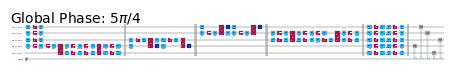

In [24]:
service = QiskitRuntimeService(instance="ibm-q-ikerbasque/internal/road-to-practiti")

if hardware:
  chosen_backend = service.least_busy(simulator=False, operational=True)
else:
  chosen_backend = FakeSherbrooke()
  chosen_backend.refresh(service)

pm = generate_preset_pass_manager(optimization_level = 2, backend=chosen_backend)

candidate_circuit_max_cut = pm.run(quc)
traspile_observavo = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut.layout)

candidate_circuit_max_cut.draw('mpl', fold=False, scale=0.1, idle_wires=False)


In [23]:
def UpdateProbabilityVector(counts, SelectedAmount):
    # Get the top 4 most probable candidates
    candidates = heapq.nlargest(SelectedAmount, counts, key=counts.get)

    # Get the number of qubits from the bitstring length (assuming all bitstrings are of the same length)
    n = len(candidates[0])  # Assuming all candidates are of the same length

    # Initialize ST as a zero vector of length n (number of qubits)
    ST = [0] * n

    # Concatenate all top candidates into a single string
    all_candidates_str = ''.join(candidates)

    # Accumulate the sums for each bit position across the concatenated candidates
    for i in range(len(all_candidates_str)):
        ST[i % n] += int(all_candidates_str[i])  # Convert binary character to in   teger

    # Normalize ST by the total number of selected candidates
    ST = [x / float(SelectedAmount) for x in ST]

    return ST

In [26]:
#Random parameters qaoa

def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    #isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    #pub = (ansatz, isa_hamiltonian, params)
    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [ ]:
#qaoa with estimator + sample (propuse qumda)

def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    #isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    #pub = (ansatz, isa_hamiltonian, params)
    global pv

    ansatz = qumda.update_distribution2(ansatz, pv)

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    jobs = sampler.run([(ansatz, params)])
    results = job.result()[0]
    results2 = jobs.result()[0]

    cost = results.data.evs
    samp_dist = results2.data.meas.get_counts()
    pv = UpdateProbabilityVector(samp_dist, 4)


    counts.append(samp_dist)
    objective_func_vals.append(cost)


    return cost

In [ ]:
#Normal qaoa, ws-qaoa (inital 0.5) and qaoa all parameter(theta)

def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    #isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    #pub = (ansatz, isa_hamiltonian, params)
    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [27]:
#Random qaoa

from scipy.optimize import minimize

classical_optimizer = minimize # Choose a classical optimization method
initial_gamma = 0.5 #Try some starting parameters
initial_beta = 0.5 #Try some starting parameters
pv = [0.5] * qumda.n_qubits #Global variable
counts = [] #Global variable
ITERATION_MAX = 35
iteration = 0

init_params = [initial_gamma, initial_beta]
result = init_params
min_cost = float('inf')
objective_func_vals = [] # Global variable

with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    for i in range(ITERATION_MAX):

      cost = cost_function(init_params, candidate_circuit_max_cut, traspile_observavo, estimator)

      if min_cost > cost:
        result = init_params

      print("Parameters: ", init_params, " Cost: ", cost)

      for i in range(len(init_params)):
         init_params[i] = np.random.uniform(-np.pi, np.pi)


    print(result)


Parameters:  [0.5, 0.5]  Cost:  -1.3766233766233764
Parameters:  [1.675750625676173, 2.5230506836380773]  Cost:  0.24575424575424576
Parameters:  [-1.2933280055283436, -0.4236294415068307]  Cost:  1.3286713286713288
Parameters:  [-2.632645212292144, 0.7912940851901307]  Cost:  -1.8741258741258742
Parameters:  [3.1259120494249135, 2.3728817592399887]  Cost:  0.061938061938061936
Parameters:  [0.7889689792508188, -0.27403288144878646]  Cost:  0.0899100899100899
Parameters:  [0.7669093309218482, -0.9285915039774992]  Cost:  0.1758241758241758
Parameters:  [1.362237435318323, 0.800460943446454]  Cost:  1.5584415584415585
Parameters:  [1.0914533932610588, -1.6685909892739994]  Cost:  -0.6413586413586413
Parameters:  [2.2776197541283123, -1.6260100876440429]  Cost:  0.1718281718281718
Parameters:  [-1.3157023009825666, 1.53574409331448]  Cost:  -0.8351648351648351
Parameters:  [0.6887405502081219, 2.3318207320669497]  Cost:  0.24775224775224775
Parameters:  [-1.437730191430699, 2.67471721126

In [ ]:
#Normal qaoa, ws-qaoa (inital 0.5) and qaoa all parameter(theta)

from scipy.optimize import minimize

classical_optimizer = minimize # Choose a classical optimization method
initial_gamma = 0.5 #Try some starting parameters
initial_beta = 0.5 #Try some starting parameters
pv = [0.5] * qumda.n_qubits #Global variable
counts = [] #Global variable

init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"


    result = minimize(
        cost_function,
        init_params,
        args=(candidate_circuit_max_cut, traspile_observavo, estimator),
        method= "COBYLA",
    )
    print(result)

In [ ]:
#qaoa all parameter(theta)

from scipy.optimize import minimize

classical_optimizer = minimize # Choose a classical optimization method
initial_gamma = 0.5 #Try some starting parameters
initial_beta = 0.5 #Try some starting parameters
initial_theta = 0.5 #Try some starting parameters
pv = [0.5] * qumda.n_qubits #Global variable
counts = [] #Global variable

init_params = [initial_gamma, initial_beta]

[init_params.append(initial_theta) for i in range(qumda.n_qubits)]

objective_func_vals = [] # Global variable
with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"


    result = minimize(
        cost_function,
        init_params,
        args=(candidate_circuit_max_cut, traspile_observavo, estimator),
        method= "COBYLA",
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.136863136863136
       x: [ 8.025e-01  7.458e-01  3.785e-02 -1.460e-01  1.767e+00
            1.558e+00  1.654e+00]
    nfev: 82
   maxcv: 0.0


In [ ]:
#qaoa with estimator + sample (propuse qumda)

from scipy.optimize import minimize

classical_optimizer = minimize # Choose a classical optimization method
initial_gamma = 0.5 #Try some starting parameters
initial_beta = 0.5 #Try some starting parameters
pv = [0.5] * qumda.n_qubits #Global variable
counts = [] #Global variable

init_params = [initial_gamma, initial_beta]

objective_func_vals = [] # Global variable
with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    sampler = Sampler(mode=chosen_backend)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"


    result = minimize(
        cost_function,
        init_params,
        args=(candidate_circuit_max_cut, traspile_observavo, estimator),
        method= "COBYLA",
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.067932067932068
       x: [-3.806e-01  1.470e+00]
    nfev: 30
   maxcv: 0.0


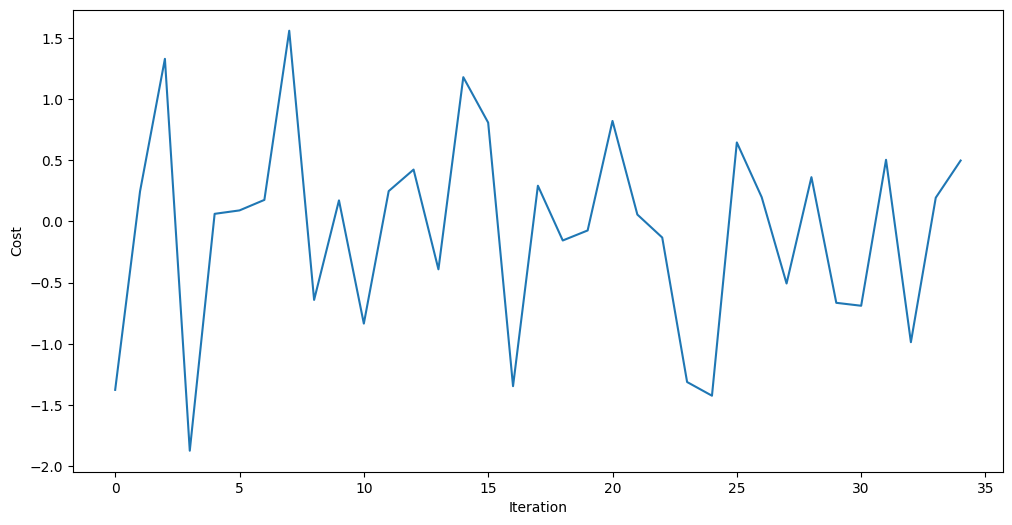

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

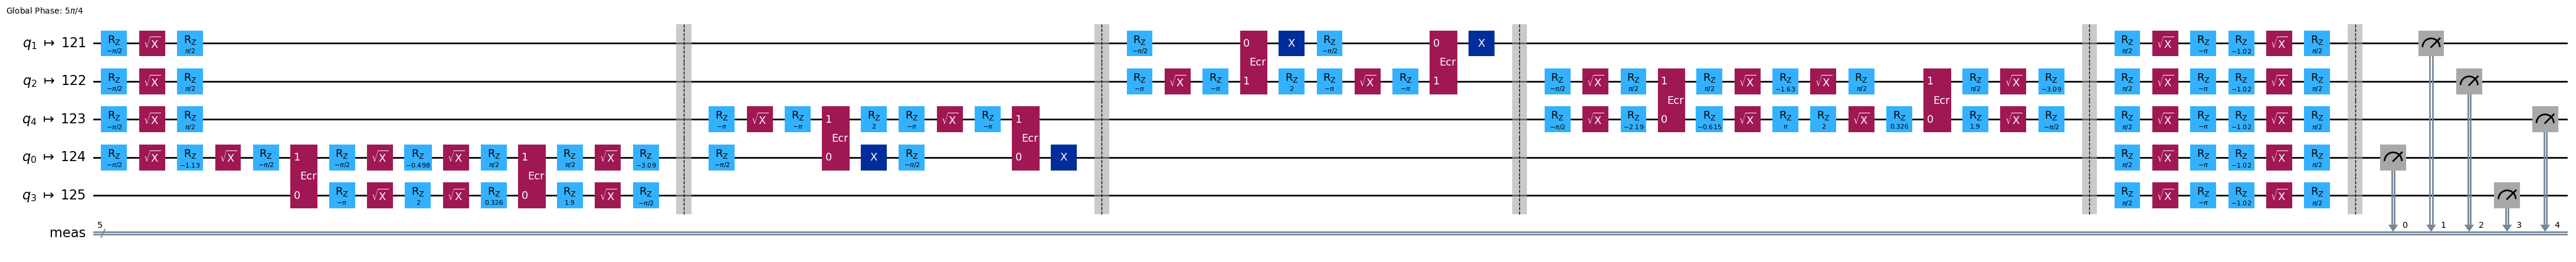

In [29]:
optimized_circuit_max_cut = candidate_circuit_max_cut.assign_parameters(result)
optimized_circuit_max_cut.draw('mpl', fold=False, idle_wires=False)

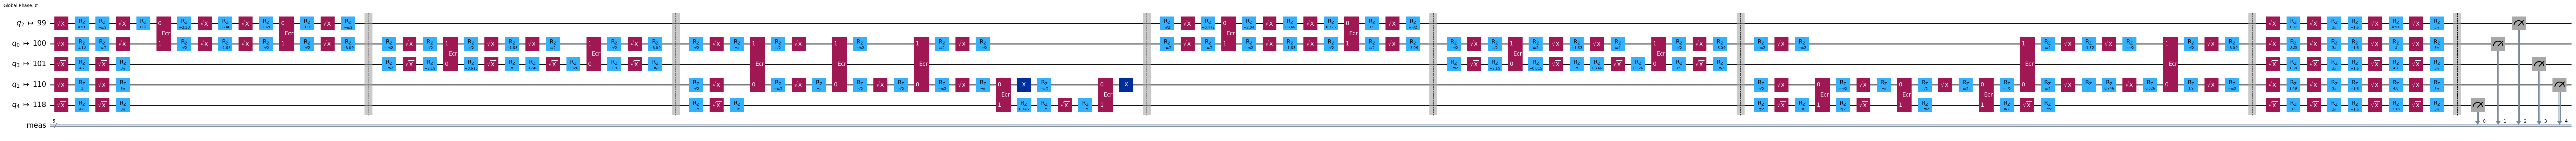

In [68]:
optimized_circuit_max_cut = candidate_circuit_max_cut.assign_parameters(result.x)
optimized_circuit_max_cut.draw('mpl', fold=False, idle_wires=False)

In [30]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`

# set shots for everything

sampler = Sampler(mode=chosen_backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"


pub= (optimized_circuit_max_cut, )
#job = sampler.run([pub], shots=int(1e4))
job = sampler.run([pub], shots=int(1000))

counts_int = job.result()[0].data.meas.get_int_counts()
shots = sum(counts_int.values())
final_distribution = {key: val/shots for key, val in counts_int.items()}

print(len(counts_int))

#Change using only keys from counts.items
#final_distribution_100_int = {key: val for key, val in final_distribution.items()}

/home/gari/miniconda3/envs/FQC/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:234: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


32


In [31]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


## Auxiliary function helping to calculate the cost for a given state (sample output)
## You dont need to understand this in detail.
def calculate_cost(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced]).real


# Add the missing code to finish this function.
def best_solution(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_sol = None

    ## Add Code here
    min_cost = float("inf")

    for sample in samples.keys():
        #Add code here
        cost = calculate_cost(sample, hamiltonian)
        #Add code here
        if min_cost > cost:
            min_cost = cost
            min_sol = sample

    return min_sol

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

best_solution = best_solution(final_distribution, cost_hamiltonian)
best_solution_string = to_bitstring(int(best_solution), len(graph_))
best_solution_string.reverse()

print("Result bitstring:", best_solution_string)

Result bitstring: [0, 1, 0, 1, 1]


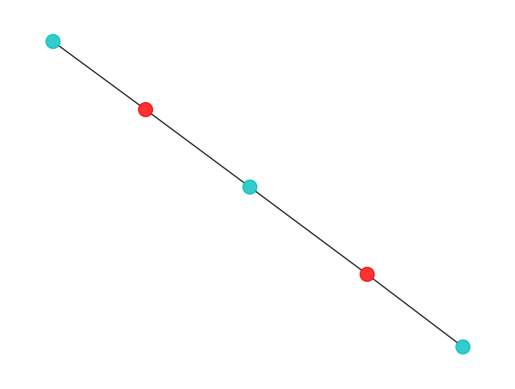

In [32]:
# auxiliary function to plot graphs
def plot_result(G, x):
    #colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    colors = ["r" if x[i] == 0 else "c" for i in range(n)]

    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph_, best_solution_string)

In [33]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))



cut_value= evaluate_sample(best_solution_string, graph_)
print('The value of the cut is:', cut_value)

The value of the cut is: 4


In [ ]:
name_str = 'Random'
graph_str = '5_graph_5'
file_name = graph_str +': '+ name_str

obj_func_cost = []
result_x = []
for i in objective_func_vals:
  obj_func_cost.append(float(i))

for i in result:
  result_x.append(float(i))

qaoa_results = {
  "file_name": file_name,
  "objective_func_cost": obj_func_cost,
  "optimal_parameters" : result,
  "beste_result_bitstring": best_solution_string,
  "value_of_cut": cut_value
}


In [ ]:
folder_path = "/home/gari/Documents/QAOA/TestResult"

file_path = os.path.join(folder_path, file_name+".json")

with open(file_path, "w") as f:
  json.dump(qaoa_results, f, indent=4)


# TEST

In [26]:
name_str = ''
graph_str = '20_graph_55'

graph_test = loaded_data[graph_str]
n = 20
p = 1
service = QiskitRuntimeService(instance="ibm-q-ikerbasque/internal/road-to-practiti")
hardware = False
qaoa_list = ['Normal', 'Random', 'Adaptive', 'All parameters']
qaoa_index = 0

folder_path = "/home/gari/Documents/QAOA/TestResult"

classical_optimizer = minimize
initial_gamma = 0.5
initial_beta = 0.5
initial_theta = 0.5

ITERATION_MAX = 30
min_cost = float('inf')

In [11]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        #paulis = ["I"] * 127
        #print(edge)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

In [27]:
max_cut_graph = build_max_cut_paulis(graph_test)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_graph)

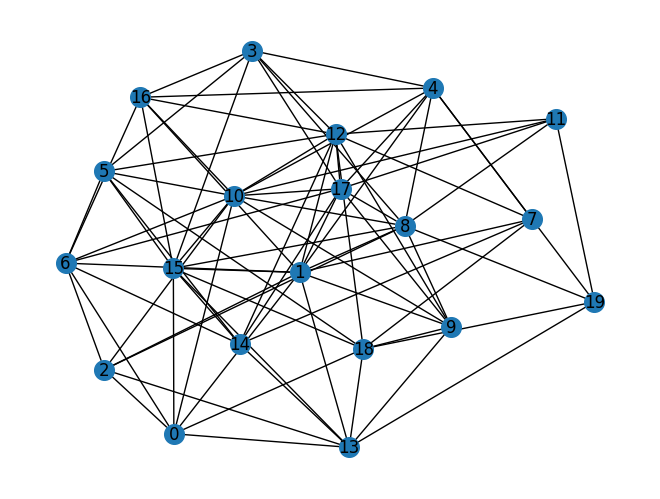

In [28]:
draw_graph(loaded_data[graph_str], node_size=200, with_labels=True, width=1)

In [29]:
qumda_test = QUMDA(p,n, cost_hamiltonian)
qumda_test_h = qumda_test.update_distribution([0.5]*n)

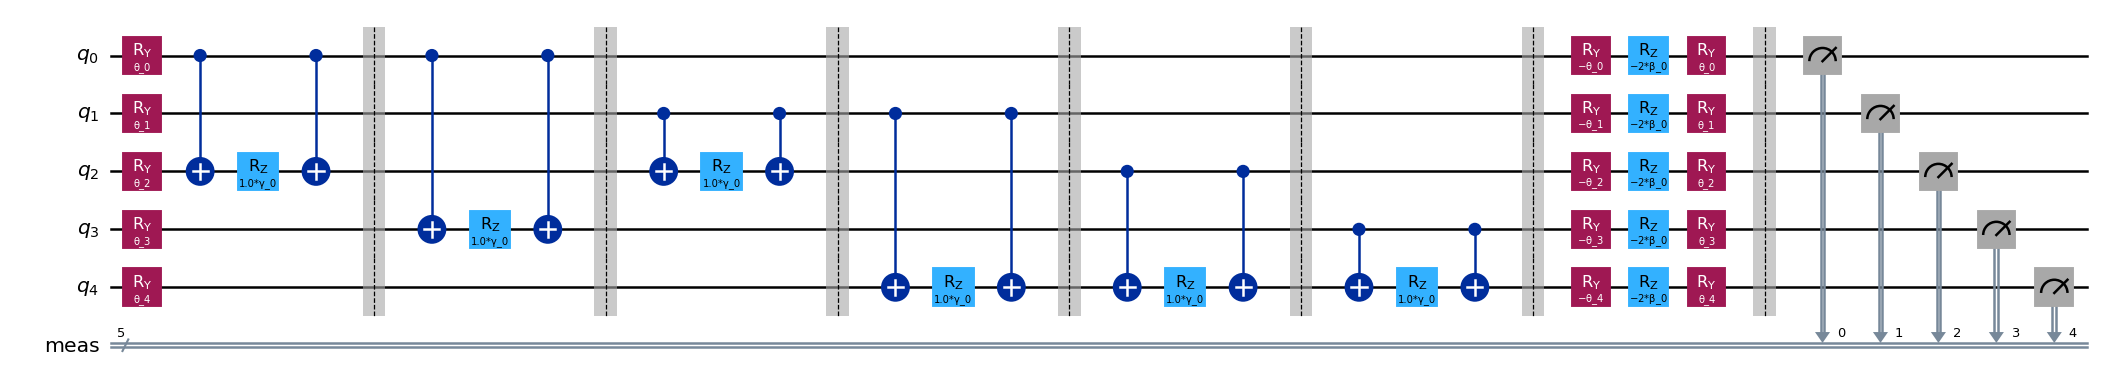

In [53]:
qumda_test.qc.draw('mpl', fold=False, scale=0.9, idle_wires=False)

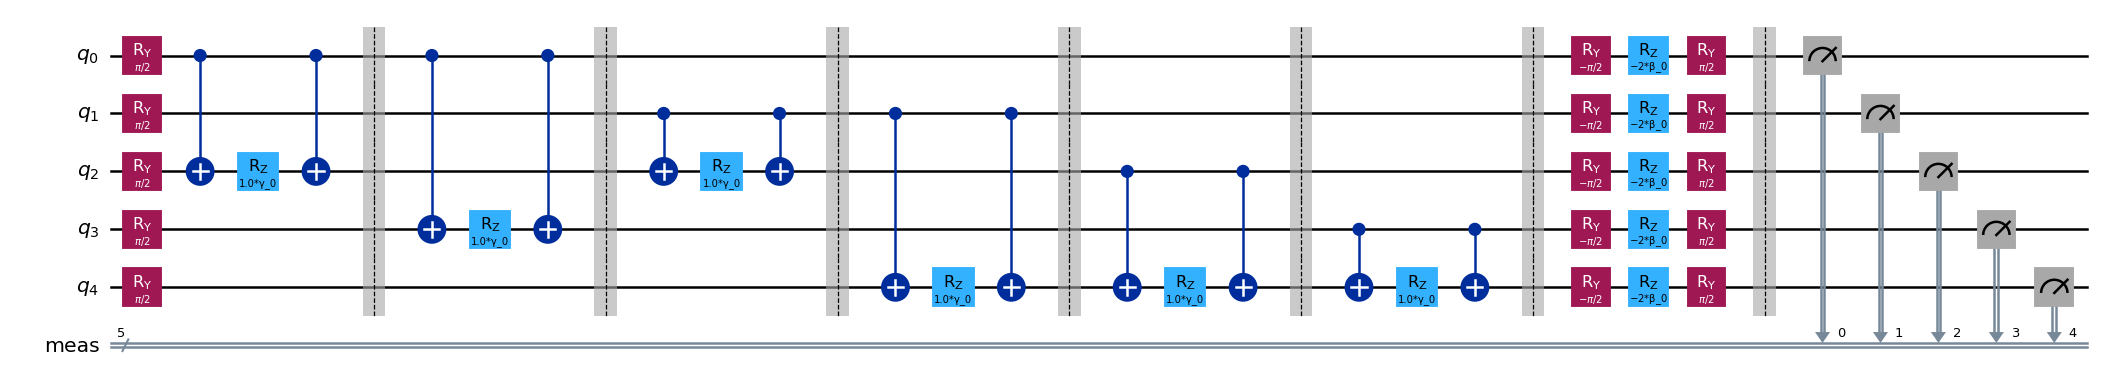

In [55]:
qumda_test_h.draw('mpl', fold=False, scale=0.9, idle_wires=False)

In [30]:
if hardware:
  chosen_backend = service.least_busy(simulator=False, operational=True)
else:
  chosen_backend = FakeSherbrooke()
  chosen_backend.refresh(service)

pm = generate_preset_pass_manager(optimization_level = 2, backend=chosen_backend)

candidate_circuit_max_cut = pm.run(qumda_test.qc)
candidate_circuit_max_cut_h = pm.run(qumda_test_h)

traspile_obserbable = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut.layout)
traspile_obserbable_h = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut_h.layout)

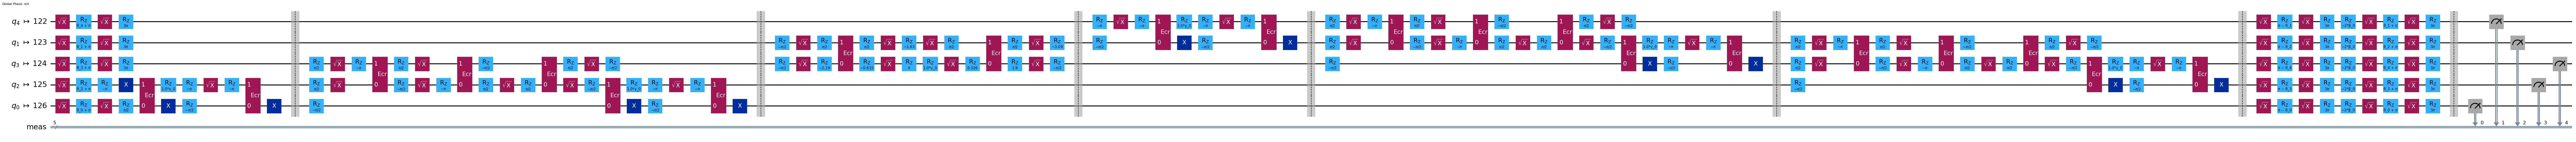

In [56]:
candidate_circuit_max_cut.draw('mpl', fold=False, scale=1.5, idle_wires=False)

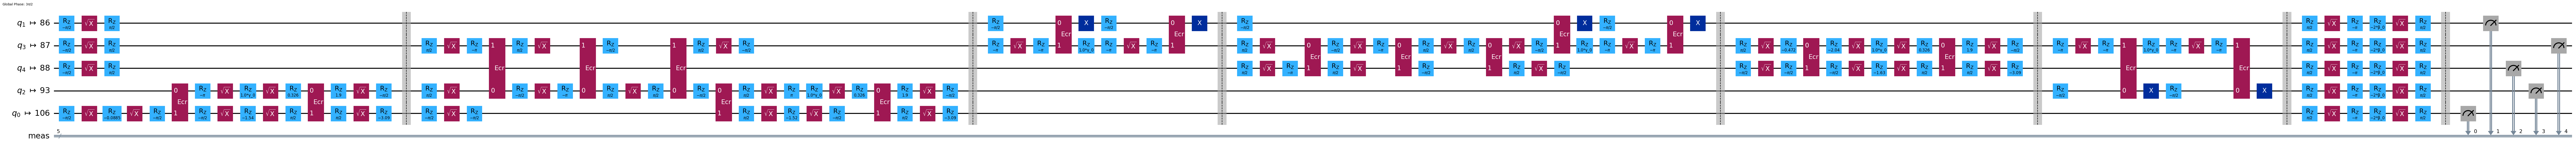

In [57]:
candidate_circuit_max_cut_h.draw('mpl', fold=False, scale=1.5, idle_wires=False)

In [17]:

def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    #isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    #pub = (ansatz, isa_hamiltonian, params)
    global pv

    if qaoa_index == 2:
      ansatz = qumda_test.update_distribution2(ansatz, pv)
      jobs = sampler.run([(ansatz, params)])
      results2 = jobs.result()[0]
      samp_dist = results2.data.meas.get_counts()
      pv = UpdateProbabilityVector(samp_dist, n)
      counts.append(samp_dist)

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [16]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


## Auxiliary function helping to calculate the cost for a given state (sample output)
## You dont need to understand this in detail.
def calculate_cost(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced]).real


# Add the missing code to finish this function.
def best_sample(samples, hamiltonian):
    """Find solution with lowest cost"""
    min_sol = None

    ## Add Code here
    min_cost = float("inf")

    for sample in samples.keys():
        #Add code here
        cost = calculate_cost(sample, hamiltonian)
        #Add code here
        if min_cost > cost:
            min_cost = cost
            min_sol = sample

    return min_sol

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))

In [ ]:
qaoa_index = 3


name_str = qaoa_list[qaoa_index]
init_params = [initial_gamma, initial_beta]
start = time.perf_counter()

if qaoa_index == 3:
    [init_params.append(initial_theta) for i in range(qumda_test.n_qubits)]

objective_func_vals = [] # Global variable
counts = [] #Global variable
pv = [0.5] * qumda_test.n_qubits #Global variable

if qaoa_index <= 1:
    candiate = candidate_circuit_max_cut_h
    transpile_obs = traspile_obserbable_h

else:
    candiate = candidate_circuit_max_cut
    transpile_obs = traspile_obserbable

with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)

    if qaoa_index == 2:
        sampler = Sampler(mode=chosen_backend)

    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    if qaoa_index == 1:
        for i in range(ITERATION_MAX):

            cost = cost_function(init_params, candiate, transpile_obs, estimator)

            if min_cost > cost:
                result = init_params


            for i in range(len(init_params)):
                init_params[i] = np.random.uniform(-np.pi, np.pi)

        result_x = result

    else:
        result = minimize(
            cost_function,
            init_params,
            args=(candiate, transpile_obs, estimator),
            method= "COBYLA",
            options={'maxiter':35}
        )
        print(result)
        result_x = result.x


#Optimal circuit
if qaoa_index == 2:
    candiate = qumda_test.update_distribution2(candiate, pv)
optimized_circuit_max_cut = candiate.assign_parameters(result_x)

#Sample of circuit
sampler = Sampler(mode=chosen_backend)
sampler.options.default_shots = 10000
pub= (optimized_circuit_max_cut, )
#job = sampler.run([pub], shots=int(1e4))
job = sampler.run([pub])

counts_int = job.result()[0].data.meas.get_int_counts()
shots = sum(counts_int.values())
final_distribution = {key: val/shots for key, val in counts_int.items()}

#Best solution
best_solution = best_sample(final_distribution, cost_hamiltonian)
best_solution_string = to_bitstring(int(best_solution), len(graph_test))
best_solution_string.reverse()

#Cut value
cut_value= evaluate_sample(best_solution_string, graph_test)

end = time.perf_counter()
elapsed = end - start

#Save result
file_name = graph_str +': '+ name_str
obj_func_cost = []
results_x = []
sample_dist = []

for i in objective_func_vals:
    obj_func_cost.append(float(i))

for i in result_x:
    results_x.append(float(i))

qaoa_results = {
    "file_name": file_name,
    "objective_func_cost": obj_func_cost,
    "sample_distribution" : counts,
    "optimal_parameters" : results_x,
    "beste_result_bitstring": best_solution_string,
    "value_of_cut": cut_value,
    "elapsed_time_seconds": round(elapsed, 4)
}


file_path = os.path.join(folder_path, file_name+".json")

with open(file_path, "w") as f:
    json.dump(qaoa_results, f, indent=4)


qaoa_index+=1


In [ ]:
qaoa_index = 0

#qaoa_list2 = [qaoa_list[2], qaoa_list[3]]
#qaoa_index = 2

for i in qaoa_list:

    start = time.perf_counter()
    name_str = i
    init_params = [initial_gamma, initial_beta]

    if qaoa_index == 3:
        [init_params.append(initial_theta) for i in range(qumda_test.n_qubits)]

    objective_func_vals = [] # Global variable
    counts = [] #Global variable
    pv = [0.5] * qumda_test.n_qubits #Global variable

    if qaoa_index <= 1:
        candiate = candidate_circuit_max_cut_h
        transpile_obs = traspile_obserbable_h

    else:
        candiate = candidate_circuit_max_cut
        transpile_obs = traspile_obserbable


    with Session(backend=chosen_backend) as session:
        # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
        estimator = Estimator(mode=session)

        if qaoa_index == 2:
            sampler = Sampler(mode=chosen_backend)

        estimator.options.default_shots = 1000

        # Set simple error suppression/mitigation options
        #estimator.options.dynamical_decoupling.enable = True
        #estimator.options.dynamical_decoupling.sequence_type = "XY4"
        #estimator.options.twirling.enable_gates = True
        #estimator.options.twirling.num_randomizations = "auto"

        if qaoa_index == 1:
            for i in range(ITERATION_MAX):

                cost = cost_function(init_params, candiate, transpile_obs, estimator)

                if min_cost > cost:
                    result = init_params


                for i in range(len(init_params)):
                    init_params[i] = np.random.uniform(-np.pi, np.pi)

            result_x = result

        else:
            result = minimize(
                cost_function,
                init_params,
                args=(candiate, transpile_obs, estimator),
                method= "COBYLA",
                options={'maxiter':35}
            )
            print(result)
            result_x = result.x


    #Optimal circuit
    if qaoa_index == 2:
        candiate = qumda_test.update_distribution2(candiate, pv)
    optimized_circuit_max_cut = candiate.assign_parameters(result_x)

    #Sample of circuit
    sampler = Sampler(mode=chosen_backend)
    sampler.options.default_shots = 10000
    pub= (optimized_circuit_max_cut, )
    #job = sampler.run([pub], shots=int(1e4))
    job = sampler.run([pub])

    counts_int = job.result()[0].data.meas.get_int_counts()
    shots = sum(counts_int.values())
    final_distribution = {key: val/shots for key, val in counts_int.items()}

    #Best solution
    best_solution = best_sample(final_distribution, cost_hamiltonian)
    best_solution_string = to_bitstring(int(best_solution), len(graph_test))
    best_solution_string.reverse()

    #Cut value
    cut_value= evaluate_sample(best_solution_string, graph_test)

    end = time.perf_counter()
    elapsed = end - start

    #Save result
    file_name = graph_str +': '+ name_str
    obj_func_cost = []
    results_x = []
    sample_dist = []

    for i in objective_func_vals:
        obj_func_cost.append(float(i))

    for i in result_x:
        results_x.append(float(i))

    qaoa_results = {
        "file_name": file_name,
        "objective_func_cost": obj_func_cost,
        "sample_distribution" : counts,
        "optimal_parameters" : results_x,
        "beste_result_bitstring": best_solution_string,
        "value_of_cut": cut_value,
        "elapsed_time_seconds": round(elapsed, 4)
    }

    file_path = os.path.join(folder_path, file_name+".json")

    with open(file_path, "w") as f:
        json.dump(qaoa_results, f, indent=4)


    qaoa_index+=1

In [1]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [110]:
name_str = ''
graph_strs = ['5_graph_5', '10_graph_12', '10_graph_15', '12_graph_18', '15_graph_24']
graph_str = graph_strs[2]
qaoa_list = ['Normal', 'Random', 'Adaptive', 'All parameters']
folder_path = "/home/gari/Documents/QAOA/TestResult"


color = ['teal', 'darkorange', 'red', 'green']
data = []

for i in qaoa_list:
    file_name = graph_str +': '+ i
    file_path = os.path.join(folder_path, file_name+".json")
    with open(file_path, "r") as f:
        data.append(json.load(f))


# Objective function plot
def objective_plot(qaoa_list, data, color):
    plt.figure(figsize=(10, 5))
    for i in range(len(qaoa_list)):
        plt.plot(data[i]["objective_func_cost"], marker='o', linestyle='-', color=color[i], label=qaoa_list[i])

    plt.title('Objective Function Cost Over Iterations:')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()

# # Elapsed time plot
def elapsed_time_plot(qaoa_list, data, color, minute):
    plt.figure(figsize=(8, 5))

    # Prepare bar positions and labels
    x = range(len(qaoa_list))  # [0, 1, 2, ...]
    labels = [i for i in qaoa_list]

    # Optionally convert seconds to minutes
    times = [item["elapsed_time_seconds"] / 60 if minute else item["elapsed_time_seconds"] for item in data]

    # Draw bars
    for i in x:
        plt.bar(x[i], times[i], color=color[i])

    # X-axis setup
    plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
    plt.ylabel("Time (Minutes)" if minute else "Time (Seconds)")
    plt.title("Total Elapsed Time per Run")
    plt.tight_layout()
    plt.show()


def total_elapsed_time_plot(qaoa_list, graph_strs, color, minute, folder_path):
    # Prepare data: one total time per graph per algorithm
    total_times_by_algo = {algo: [] for algo in qaoa_list}

    for graph_str in graph_strs:
        for i, algo in enumerate(qaoa_list):
            file_name = graph_str + ': ' + algo
            file_path = os.path.join(folder_path, file_name + ".json")
            with open(file_path, "r") as f:
                data = json.load(f)
                total_time = data["elapsed_time_seconds"]
                if minute:
                    total_time /= 60
                total_times_by_algo[algo].append(total_time)

    # Plot one line per algorithm
    plt.figure(figsize=(10, 5))

    for i, algo in enumerate(qaoa_list):
        plt.plot(graph_strs, total_times_by_algo[algo], marker='o', linestyle='-', color=color[i], label=algo)

    plt.title("Total Elapsed Time per Graph")
    plt.xlabel("Graph")
    plt.ylabel("Time (Minutes)" if minute else "Time (Seconds)")
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()


# # Value of the cut plot
def value_cut_plot(qaoa_list, data, color):
    plt.figure(figsize=(8, 5))

    # Prepare bar positions and labels
    x = range(len(qaoa_list))  # [0, 1, 2, ...]
    labels = [i for i in qaoa_list]

    # Draw bars
    for i in x:
        plt.bar(x[i], data[i]["value_of_cut"], color=color[i])

    # X-axis setup
    plt.xticks(ticks=x, labels=labels, rotation=45, ha='right')
    plt.ylabel("Value of cut")
    plt.title("Cut Value")
    plt.tight_layout()
    plt.show()


def varianza_estimation_plot(data, color):

    # Extract the list of sample distributions
    sample_distributions = data[2]["sample_distribution"]

    # Estimate variance for each sample distribution
    estimated_variances = [np.var(list(dist.values())) for dist in sample_distributions]

    # Plotting the estimated variance over iterations
    plt.plot(range(len(estimated_variances)), estimated_variances, color=color[2])
    plt.xlabel("Iteration")
    plt.ylabel("Estimated Variance")
    plt.title("Convergence of Variance Estimation")
    #plt.grid(True)
    plt.show()


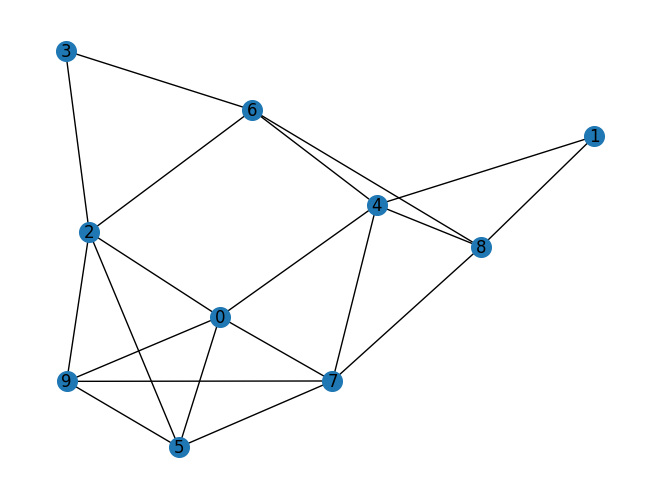

In [111]:
draw_graph(loaded_data[graph_str], node_size=200, with_labels=True, width=1)

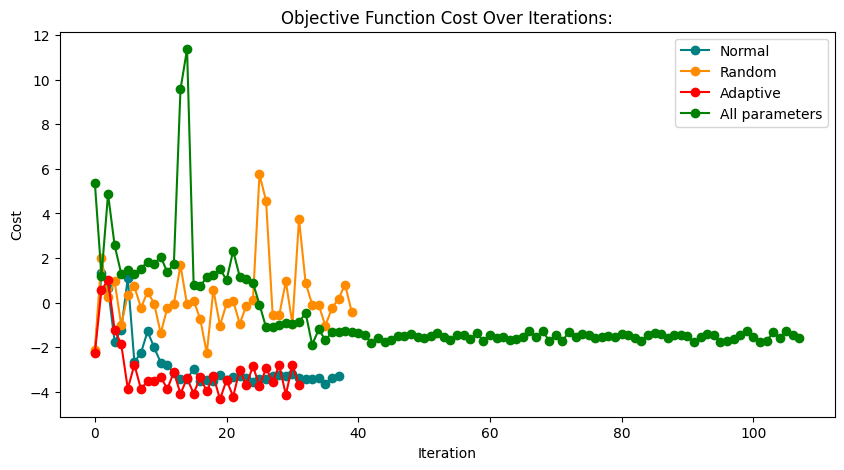

In [112]:
objective_plot(qaoa_list, data, color)

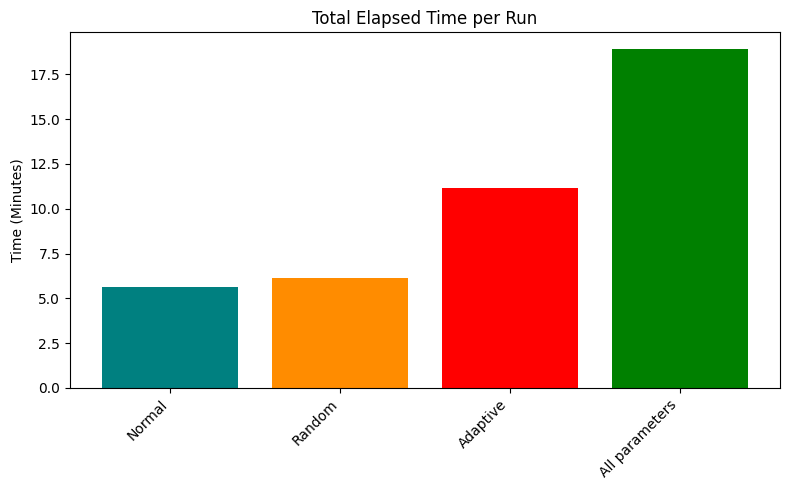

In [113]:
elapsed_time_plot(qaoa_list, data, color, True)

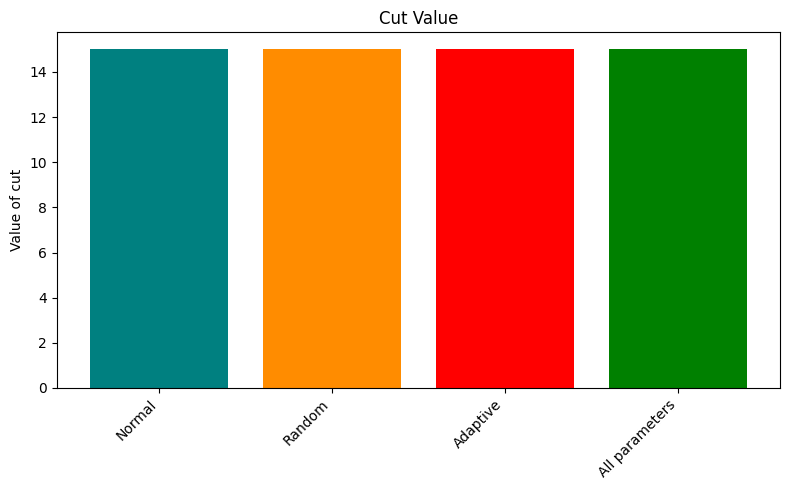

In [97]:
value_cut_plot(qaoa_list, data, color)

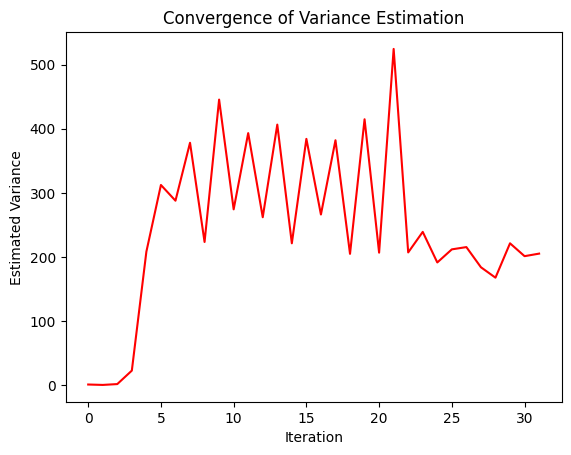

In [98]:
varianza_estimation_plot(data, color)

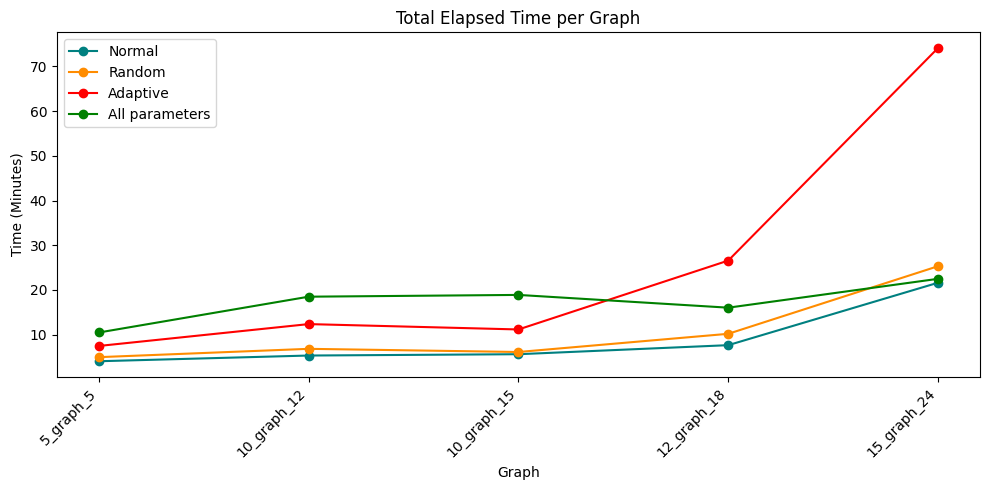

In [93]:
total_elapsed_time_plot(qaoa_list, graph_strs, color, True, folder_path)